# Translator Use Case Question 4: Lung adenocarcinoma and bosutinib

2020-11-26 update: currently the query is not working. Look at the corresponding html file for a snapshot of the results when the workflow worked. Also, Hint module results changed so the object selections were changed.

## Understanding the Question

**To experiment with an executable version of this notebook, [load it in Google Colaboratory](https://colab.research.google.com/github/colleenXu/biothings_explorer/blob/relay/jupyter%20notebooks/TranslatorUseCases/TranslatorUseCase_Q4_LungAdenocarcinoma_bosutinib.ipynb).**

The Translator Use Case Question #4 is:    

> For a patient with disease X, what are some factors (such as genetic features, comorbidities, etc) that could cause sensitivity or resistance to drug Y? 

We interpret the Translator Use Case Question to be about several somewhat-related issues:
* in the context of cancer, drug sensitivity means that the drug has the desired effect of killing or inhibiting cancerous cells and drug resistance means that the drug does not have this desired effect (this resistance can be pre-existing or can develop with time / exposure to the drug). [Reference](https://www.merckmanuals.com/home/drugs/factors-affecting-response-to-drugs/tolerance-and-resistance-to-drugs).
    * There are [multiple overarching factors](https://www.nature.com/articles/s41586-019-1730-1) to drug resistance in this context.
* in the context of pathogens and the diseases they cause, drug sensitivity (similar to the cancer context) means that the drug has the desired effect of killing or inhibiting the pathogens and drug resistance (similar to the cancer context) means that the drug does not have this desired effect. [Reference](https://www.merckmanuals.com/home/drugs/factors-affecting-response-to-drugs/tolerance-and-resistance-to-drugs). 
* outside of the above contexts, drug sensitivity often means that [the patient is unable to tolerate the drug due to adverse events](https://en.wikipedia.org/wiki/Drug_intolerance). These adverse events could be [drug allergies / hypersensitivity reactions, drug side effects, drug intolerances](https://www.racgp.org.au/afp/2013/januaryfebruary/adverse-drug-reactions/), or [adverse drug-disease interactions](https://www.drugs.com/drug_interactions.html). Drug tolerance can refer to [patients who require greater doses of a drug](https://www.merckmanuals.com/professional/clinical-pharmacology/factors-affecting-response-to-drugs/pharmacogenetics) to achieve therapeutic concentrations and effects. 
    * Genetic factors, environmental factors, and developmental factors affect drug response and metabolism. [Reference](https://www.merckmanuals.com/professional/clinical-pharmacology/factors-affecting-response-to-drugs/pharmacogenetics). 
    * This question then begins to overlap with Translator Use Case Question #5. 

**In this notebook, we will tackle the first context (cancer) and genes of cancer cells that could correlate with the cells' sensitivity or resistance to a drug.** 

**We therefore decided to reframe this question and ask:**
> What genes are commonly mutated in the context of `Disease` X (cancer) AND are associated with increased sensitivity to `ChemicalSubstance` Y (in the same `Disease` context)?

BioThings Explorer (BTE) can answer two classes of queries -- "Explain" and "Predict". This Question fits the Explain  template of starting with **a specific biomedical entity** (a specific `Disease` X) and finding indirect relationships with **another specific biomedical entity** (a specific `ChemicalSubstance` Y).

*However, this version of BTE is still in active development, so the actual function this notebook runs is a modified Predict query to match the "Explain" template.*

## Specific use case: lung adenocarcinoma and bosutinib

We will use **lung adenocarcinoma** as our specific disease of interest. We will use **bosutinib** as our drug of interest. [Bosutinib](https://www.drugs.com/ppa/bosutinib.html) is used to treat CML, and it is known to inhibit BCR-ABL kinase and the SRC family. 

An expected result (gene) of this query is EGFR. 
* Bosutinib has been linked to reduced cancer cell proliferation and induced cell apoptosis in sensitive cell lines. In that study, bosutinib was linked to inhibition of EGFR phosphorylation (activation), and the sensitive cell lines were linked with high EGFR activity (increased EGFR gene copy number and expression, [Reference](https://www.mdpi.com/1422-0067/19/7/1824/htm)). 
* Lung adenocarcinoma is known to have [aberrant EGFR activation and activity](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6962979/) (although there is [some controversy](https://pubmed.ncbi.nlm.nih.gov/21994417/) around using EGFR expression as a diagnostic biomarker to predict response to specific therapies, due to issues with the testing method). 

We tackle the search for genes associated with bosutinib and lung adenocarcinoma using the query:  
* `Disease`lung adenocarcinoma  &rarr; results:`Gene` &larr; `ChemicalSubstance` bosutinib. 
* For the first part of the query, `Disease` lung adenocarcinoma  &rarr; `Gene`, we will add a filter: that the gene must be commonly mutated (aka mutated in > 10% of lung adenocarcinoma samples). 
* For the second part of the query, `ChemicalSubstance` bosutinib &rarr; `Gene`, we will add filters to focus on genes involved in increased sensitivity to bosutinib (effect size < 0 and p-value < 0.05, meaning inhibition happened with lower drug concentrations) in the context of lung adenocarcinoma 
* The query will return a graph object with entities as nodes and relationships as edges. We then use edge provenance information to **filter** the results. For each intermediate Gene node, we use the number of unique paths from the input nodes to that node to **score** it. For this demo, the scores for all Genes will be the same. 

## Step 0: Load BTE modules, notebook functions

In [ ]:
## for Google Colab
%%capture
!pip install git+https://github.com/colleenXu/biothings_explorer@relay#egg=biothings_explorer
!pip install git+https://github.com/mmayers12/data_tools

In [1]:
## CX: allows multiple lines of code to print from one code block
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# import modules from biothings_explorer
from biothings_explorer.hint import Hint
from biothings_explorer.query.predict import Predict  

## to visualize, depends on data_tools package from Su/Wu Lab from https://github.com/mmayers12/data_tools
from biothings_explorer.query.visualize import display_graph  
%matplotlib inline

## show time that this notebook was executed 
from datetime import datetime

## packages to work with objects 
import re

## to get around bugs
import nest_asyncio
nest_asyncio.apply()
import warnings
warnings.filterwarnings("ignore")

/Users/jay/miniconda3/envs/BTE2/lib/python3.7/site-packages/data_tools/df_processing.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
## functions to add to modules?
def hint_display(query, hint_result):
    """
    show the type, name, number of IDs for all results returned by the query
    
    :param: query: string used in hint query
    :param: hint_result: object returned from hint query, a dictionary of lists of dictionaries
    
    Returns: None
    """
    ## function needs to be rewritten if it's going to give the exact index of each object within its type 
    display = ['type', 'name']  ## replace with the parts of the BioThings object you want to see
    concise_results = []
    for BT_type, result in hint_result.items():
        if result:  ## basically if it's not empty
            for items in result:
                ## number of identifiers per object: number of keys - 4 (name, primary, display, type)
                temp = len(items) - 4
                concise_results.append((items[display[0]], items[display[1]], 
                                         str(temp)))
                    
    print('There are {total} BioThings objects returned for {ht}:'.format(\
                total = len(concise_results), ht = query))
    for display_info in concise_results:
        print('{0}, {1}, num of IDs: {2}'.format(display_info[0], display_info[1], display_info[2]))

In [3]:
## uses _label suffix for columns

def scoring_output(df, q_type):
    """
    score results based on whether query was Predict or Explain type, number of 
        intermediate nodes 
    :param: pandas dataframe containing results from BTE FindConnection module
    :param: string describing type of query (Predict or Explain)
    
    May flatten some edges, because score only counts one edge per 
        unique predicate / API / method (ignoring source and pubmed col)
    
    Predict queries: score each output node by counting # of paths
        from input nodes to it. Normalize by dividing by maximum
        possible # of paths
    Explain two-hop (one intermediate) queries: score each intermediate node by 
        counting # of paths (between input and output nodes) that include it. 
        Normalize by dividing by maximum possible # of paths    

    Explain one-hop (direct) queries: no need to score, prints message
    Other Explain queries (many-hops): currently not able to score, prints message     
    
    Returns: pandas series with scores, index is output_name
             or None (one-hop or many-hop Explain query)
    """
    df_temp = df.copy()  ## so no chance to mutate this   
    flag_direct = False  ## one-hop query or not
    ## use df_col to look quicker into columns
    df_col = set(df_temp.columns)
    
    ## ignore source and pubmed col in looking at unique edges 
    columns_drop = [col for col in df_col if (('_source' in col) or ('_pubmed' in col))]
    df_temp.drop(columns = columns_drop, inplace = True)    
    df_temp.drop_duplicates(inplace = True)
    
    ## check if query is one-hop or not
    if "node1_label" not in df_col:    ## name for first intermediate node layer
        flag_direct = True  
    
    if q_type == 'Explain':
        if flag_direct:   # one hop / no intermediates
            print('No valid node scoring for one-hop (direct) Explain queries.')
            return None
        ## if there are many-hops/intermediate layers
        elif "node2_label" in df_col:  ## name for 2nd intermed. node layer
            print('Cannot currently score many-hop Explain queries.')
            return None
        else:   ## two-hop / 1 intermediate layer
            ## count multi-edges to results (the intermediate node1 col)
            scores = df_temp.node1_label.value_counts() 
            ## to find the maximum-possible number of edges, look at non-result cols
            columns_drop = [col for col in df_col if 'node1' in col]
            df_temp.drop(columns = columns_drop, inplace = True)
            ## now look at number of unique combos for input, edge info, output
            df_temp.drop_duplicates(inplace = True)
            max_paths = df_temp.shape[0]            
            ## normalize scores by dividing each by max number of paths
            scores = scores / max_paths

    else:  ## Predict type query
        ## count multi-edges to results (the output col)
        scores = df_temp.output_label.value_counts()
        ## to find the maximum number of multi-edges, look at non-output col
        columns_drop = [col for col in df_temp.columns if 'output' in col]
        df_temp.drop(columns = columns_drop, inplace = True)
        ## now look at number of unique paths possible
        df_temp.drop_duplicates(inplace = True)
        max_paths = df_temp.shape[0]
        ## normalize scores by dividing each by max number of paths
        scores = scores / max_paths
            
    ## return scores as pandas dataframe, with rank
    scores = scores.to_frame(name = 'score') 
    scores['rank'] = scores['score'].rank(method = 'dense', ascending = False)
    return scores

In [4]:
## record when cell blocks are executed
print('The time that this notebook was executed is...')
print('Local time (PST, West Coast USA): ')
print(datetime.now())
print('UTC time: ')
print(datetime.utcnow())

The time that this notebook was executed is...
Local time (PST, West Coast USA): 
2020-11-26 14:20:22.930532
UTC time: 
2020-11-26 22:20:22.930659


## Step 1: Find representation of "lung adenocarcinoma" in BTE

In this step, BioThings Explorer translates our query string "lung adenocarcinoma" into BioThings objects, which contain mappings to many common identifiers. We then pick the BioThings object that best matches what we want. 

Generally, the top result returned by the Hint module for your BioThings type of interest will match what you want, but you should confirm that using the identifiers shown. 


> BioThings types correspond to children and descendants of [BiologicalEntity](https://biolink.github.io/biolink-model/docs/BiologicalEntity.html) from the [Biolink Model](https://biolink.github.io/biolink-model/docs/), including `Disease` (e.g., "lupus"), `ChemicalSubstance` (e.g., "acetaminophen"), `Gene` (e.g., "CDK2"), `BiologicalProcess` (e.g., "T cell differentiation"), and `Pathway` (e.g., "Citric acid cycle"). **However, [only a subset of the Biolink BiologicalEntity children / descendants are currently implemented in BTE](https://smart-api.info/portal/translator/metakg)**. More biomedical object types will be available as more knowledge sources (APIs) are added to the system. **Note that the type `BiologicalEntity` means any BioThings type currently implemented in BTE will be accepted.**

In [5]:
ht = Hint()  ## neater way to call this BTE module

## the human user gives this input
cancer_starting_str = "lung adenocarcinoma"

cancer_hint = ht.query(cancer_starting_str)
hint_display(cancer_starting_str, cancer_hint)

There are 9 BioThings objects returned for lung adenocarcinoma:
Gene, lung adenocarcinoma-associated transcript 1, num of IDs: 2
Gene, lung adenocarcinoma associated transcript 1, num of IDs: 5
Gene, metastasis associated lung adenocarcinoma transcript 1, num of IDs: 5
Disease, lung occult adenocarcinoma, num of IDs: 3
Disease, lung adenocarcinoma, num of IDs: 4
Disease, papillary lung adenocarcinoma, num of IDs: 3
Disease, acinar lung adenocarcinoma, num of IDs: 3
Disease, lung colloid adenocarcinoma, num of IDs: 3
PhenotypicFeature, Lung adenocarcinoma, num of IDs: 4


2020-11-26 update: Hint module results changed so the pick selection is changed. Based on the information above, we'll pick the second `Disease` choice (indexed at 1) for our query. We can look at identifier mappings inside this BioThings object. 

In [6]:
## the human user makes this choice, gives this input
cancer_choice_type = 'Disease'
cancer_choice_idx = 1

cancer_hint_obj = cancer_hint[cancer_choice_type][cancer_choice_idx]  
cancer_hint_obj

{'MONDO': 'MONDO:0005061',
 'DOID': 'DOID:3910',
 'UMLS': 'C0152013',
 'name': 'lung adenocarcinoma',
 'MESH': 'C538231',
 'primary': {'identifier': 'MONDO',
  'cls': 'Disease',
  'value': 'MONDO:0005061'},
 'display': 'MONDO(MONDO:0005061) DOID(DOID:3910) UMLS(C0152013) MESH(C538231) name(lung adenocarcinoma)',
 'type': 'Disease'}

## Step 2: Find representation of "bosutinib" in BTE

In this step, BioThings Explorer translates our query string "bosutinib"  into BioThings objects, which contain mappings to many common identifiers. We then pick the BioThings object that best matches what we want. 

In [7]:
## the human user gives this input
drug_starting_str = "bosutinib"

drug_hint = ht.query(drug_starting_str)
hint_display(drug_starting_str, drug_hint)

There are 5 BioThings objects returned for bosutinib:
ChemicalSubstance, BOSUTINIB, num of IDs: 12
ChemicalSubstance, BOSUTINIB MONOHYDRATE, num of IDs: 8
ChemicalSubstance, bosutinib, num of IDs: 2
ChemicalSubstance, bosutinib, num of IDs: 0
ChemicalSubstance, OXYDECHLORINATED BOSUTINIB HYDROGEN SULFATE, num of IDs: 1


2020-11-26 update: Hint module results changed so the pick selection is changed. All of these `ChemicalSubstance` entries seem to be the right object. We'll pick the entry with the most identifiers (the first option, indexed at 0) for our query. We can look at identifier mappings inside this BioThings object. 

In [8]:
## the human user makes this choice, gives this input
drug_choice_type = 'ChemicalSubstance'
drug_choice_idx = 0

drug_hint_obj = drug_hint[drug_choice_type][drug_choice_idx]  
drug_hint_obj

{'CHEMBL.COMPOUND': 'CHEMBL288441',
 'DRUGBANK': 'DB06616',
 'PUBCHEM': 5328940,
 'CHEBI': 'CHEBI:39112',
 'UMLS': 'C1831731',
 'MESH': 'C471992',
 'UNII': '5018V4AEZ0',
 'INCHIKEY': 'UBPYILGKFZZVDX-UHFFFAOYSA-N',
 'INCHI': 'InChI=1S/C26H29Cl2N5O3/c1-32-6-8-33(9-7-32)5-4-10-36-25-13-21-18(11-24(25)35-3)26(17(15-29)16-30-21)31-22-14-23(34-2)20(28)12-19(22)27/h11-14,16H,4-10H2,1-3H3,(H,30,31)',
 'name': 'BOSUTINIB',
 'CAS': '380843-75-4',
 'IUPAC': '4-(2,4-dichloro-5-methoxy-anilino)-6-methoxy-7-[3-(4-methylpiperazino)propoxy]quinoline-3-carbonitrile',
 'formula': 'C26H29Cl2N5O3',
 'primary': {'identifier': 'CHEBI',
  'cls': 'ChemicalSubstance',
  'value': 'CHEBI:39112'},
 'display': 'CHEBI(CHEBI:39112) CHEMBL.COMPOUND(CHEMBL288441) DRUGBANK(DB06616) PUBCHEM(5328940) MESH(C471992) UNII(5018V4AEZ0) UMLS(C1831731) name(BOSUTINIB) CAS(380843-75-4) IUPAC(4-(2,4-dichloro-5-methoxy-anilino)-6-methoxy-7-[3-(4-methylpiperazino)propoxy]quinoline-3-carbonitrile) formula(C26H29Cl2N5O3)',
 'type': '

## Step 3: Lung adenocarcinoma &rarr; Gene &larr; bosutinib

2020-11-26 update: currently the query is not working. The code results below are from Local time (PST, West Coast USA): 2020-09-19 21:37:59.598803, UTC time: 2020-09-20 04:37:59.598948. Look at the corresponding html file for a snapshot of the results when the workflow worked. 

In this section, we dynamically generate a knowledge graph with paths connecting lung adenocarcinoma and the drug bosutinib to `Genes`, with our desired filters on edge info. We will then look at the `Gene` results. 
* For the first part of the query, `Disease` lung adenocarcinoma  &rarr; `Gene`, we will add a filter: that the gene must be commonly mutated (aka mutated in > 10% of lung adenocarcinoma samples). 
* For the second part of the query, `ChemicalSubstance` bosutinib &rarr; `Gene`, we will add filters to focus on genes involved in increased sensitivity to bosutinib (effect size < 0 and p-value < 0.05, meaning inhibition happened with lower drug concentrations) in the context of lung adenocarcinoma 

BTE performs the **query path planning** and **query path execution** by deconstructing the query into individual API calls, executing those API calls, and then assembling the results.

In [10]:
## human sets these parameters for filtering
query_config = {
    "filters": [{
                "frequency": {">": 0.1}}, ## cancer -> Gene filter
                {"disease_context": {"=": cancer_hint_obj['MONDO']},  ## Gene -> ChemicalSubstance filters
                 "pvalue": {"<": 0.05},
                 "effect_size": {"<": 0.00}
                }],
    "predicates": [None, None]  ## no restrictions on predicates
}

In [11]:
## note: this notebook uses Predict-query with filter afterwards to match an Explain-type query
## an explain query would be faster

## human sets desired types 
pd_intermediates = ['Gene']
pd_output = ['ChemicalSubstance']

pd = Predict(
    input_objs = [cancer_hint_obj],
    intermediate_nodes = pd_intermediates, 
    output_types = pd_output, 
    config = query_config
)
pd.connect(verbose = True)

========== QUERY PARAMETER SUMMARY ==========

Your query have 1 input nodes, including lung adenocarcinoma .... And BTE will find paths that connect your input nodes to your output types ['ChemicalSubstance']. Paths will contain 1 intermediate nodes.

Intermediate node #1 will have these type constraints: Gene

========== Query # 1 ==========

==== Step #1: Query Path Planning ====

Input Types: Disease
Output Types: Gene
Predicates: None

BTE found 12 APIs

API 1. TCGA Mutation Frequency KP API (1 API calls)
API 2. Automat CORD19 Scigraph API (1 API calls)
API 3. mydisease.info API (1 API calls)
API 4. SEMMED Disease API (15 API calls)
API 5. MGIgene2phenotype API (1 API calls)
API 6. Automat CORD19 Scibite API (1 API calls)
API 7. Automat PHAROS API (1 API calls)
API 8. BioLink API (2 API calls)
API 9. DISEASES API (1 API calls)
API 10. Molecular Data Provider API (1 API calls)
API 11. Genetics Provider API (1 API calls)
API 12. CORD Disease API (1 API calls)


==== Step #2: Query p

API 4.3 OpenTarget API: 0 hits
API 4.3 OpenTarget API: 0 hits after applying filters
API 4.4: https://platform-api.opentargets.io/v3/platform/public/evidence/filter?datasource=chembl&fields=drug&size=100&target=ENSG00000181143
API 4.4 OpenTarget API: 20 hits
API 4.4 OpenTarget API: 0 hits after applying filters
API 1.1: https://biothings.ncats.io/drug_response_kp/query?fields=association.context.disease.mondo,object.PUBCHEM,association.effect_size,association.pvalue&q=subject.NCBIGene:7157 AND association.effect_size:<0 AND association.pvalue:<0.05&size=1000&sort=association.pvalue
API 1.1: https://biothings.ncats.io/drug_response_kp/query?fields=association.context.disease.mondo,object.PUBCHEM,association.effect_size,association.pvalue&q=subject.NCBIGene:114788 AND association.effect_size:<0 AND association.pvalue:<0.05&size=1000&sort=association.pvalue
API 1.1 Drug Response KP API: 129 hits
API 1.1 Drug Response KP API: 2 hits after applying filters
API 1.2 Drug Response KP API: 61 h

API 1.6 Drug Response KP API: 88 hits
API 1.6 Drug Response KP API: 0 hits after applying filters
API 1.7 Drug Response KP API: 154 hits
API 1.7 Drug Response KP API: 32 hits after applying filters
API 4.5: https://platform-api.opentargets.io/v3/platform/public/evidence/filter?datasource=chembl&fields=drug&size=100&target=ENSG00000133703
API 4.5 OpenTarget API: 0 hits
API 4.5 OpenTarget API: 0 hits after applying filters
API 4.6: https://platform-api.opentargets.io/v3/platform/public/evidence/filter?datasource=chembl&fields=drug&size=100&target=ENSG00000042781
API 4.6 OpenTarget API: 0 hits
API 4.6 OpenTarget API: 0 hits after applying filters
API 1.8: https://biothings.ncats.io/drug_response_kp/query?fields=association.context.disease.mondo,object.PUBCHEM,association.effect_size,association.pvalue&q=subject.NCBIGene:3845 AND association.effect_size:<0 AND association.pvalue:<0.05&size=1000&sort=association.pvalue
API 1.8 Drug Response KP API: 61 hits
API 1.8 Drug Response KP API: 11 h

API 10.5 SEMMED Gene API: 384 hits
API 10.5 SEMMED Gene API: 0 hits after applying filters
API 10.6: https://biothings.ncats.io/semmedgene/query?fields=positively_regulated_by (POST -d q=C1416775,C1421222,C1413796,C1419780,C1826727,C1414103,C1413591,C2239455,C1428779,C1420709,C1426144,C1539388,C1414101,C1413801,C1538894,C1426851,C1424731,C1413270,C1422527,C1427969,C1537596,C1419778,C1414128,C1425837,C1418306,C1538571,C1416914,C1427037,C1414094,C1426709,C1417516,C0078193,C1837877,C0146283,C1417656,C1969059,C1422786,C1421975,C1427797,C1426145,C1414100,C1413683,C0079419,C2239906,C1413578,C1417851,C1825094,C1412295,C0117738,C1537461,C1414313,C1422001,C1419126,C1424044,C1414083,C3147261,C1421976,C1422331,C1418643,C1413283,C1420044,C1537481,C1427840,C0694883,C1825113,C1539119,C1826605,C1413763,C1417537,C1538511,C1412403,C1423850,C1423898,C1424800,C1416776,C1413572,C1539447,C1417498,C1824069,C0040123,C1423594,C0812248,C1336636,C1420385,C1424559,C1422390,C1418452,C1537502,C1425978,C1424490,C14

API 10.9 SEMMED Gene API: 0 hits
API 10.9 SEMMED Gene API: 0 hits after applying filters
API 4.15: https://platform-api.opentargets.io/v3/platform/public/evidence/filter?datasource=chembl&fields=drug&size=100&target=ENSG00000150275
API 4.15 OpenTarget API: 0 hits
API 4.15 OpenTarget API: 0 hits after applying filters
API 4.16: https://platform-api.opentargets.io/v3/platform/public/evidence/filter?datasource=chembl&fields=drug&size=100&target=ENSG00000067798
API 4.16 OpenTarget API: 0 hits
API 4.16 OpenTarget API: 0 hits after applying filters
API 4.17: https://platform-api.opentargets.io/v3/platform/public/evidence/filter?datasource=chembl&fields=drug&size=100&target=ENSG00000198597
API 4.17 OpenTarget API: 0 hits
API 4.17 OpenTarget API: 0 hits after applying filters
API 4.18: https://platform-api.opentargets.io/v3/platform/public/evidence/filter?datasource=chembl&fields=drug&size=100&target=ENSG00000169876
API 4.18 OpenTarget API: 0 hits
API 4.18 OpenTarget API: 0 hits after applying

API 4.22 OpenTarget API: 5 hits
API 4.22 OpenTarget API: 0 hits after applying filters
API 4.23: https://platform-api.opentargets.io/v3/platform/public/evidence/filter?datasource=chembl&fields=drug&size=100&target=ENSG00000084674
API 4.23 OpenTarget API: 7 hits
API 4.23 OpenTarget API: 0 hits after applying filters
API 4.24: https://platform-api.opentargets.io/v3/platform/public/evidence/filter?datasource=chembl&fields=drug&size=100&target=ENSG00000079999
API 4.24 OpenTarget API: 63 hits
API 4.24 OpenTarget API: 0 hits after applying filters
API 1.20: https://biothings.ncats.io/drug_response_kp/query?fields=association.context.disease.mondo,object.PUBCHEM,association.effect_size,association.pvalue&q=subject.NCBIGene:9817 AND association.effect_size:<0 AND association.pvalue:<0.05&size=1000&sort=association.pvalue
API 1.20 Drug Response KP API: 21 hits
API 1.20 Drug Response KP API: 6 hits after applying filters
API 1.21: https://biothings.ncats.io/drug_response_kp/query?fields=associat

API 1.28 Drug Response KP API: 59 hits
API 1.28 Drug Response KP API: 0 hits after applying filters
API 1.29: https://biothings.ncats.io/drug_response_kp/query?fields=association.context.disease.mondo,object.PUBCHEM,association.effect_size,association.pvalue&q=subject.NCBIGene:1770 AND association.effect_size:<0 AND association.pvalue:<0.05&size=1000&sort=association.pvalue
API 1.29 Drug Response KP API: 65 hits
API 1.29 Drug Response KP API: 2 hits after applying filters
API 8.21: https://automat.renci.org/hmdb/gene/chemical_substance/NCBIGene:81792
API 8.21 Automat HMDB API: 0 hits
API 8.21 Automat HMDB API: 0 hits after applying filters
API 8.22: https://automat.renci.org/hmdb/gene/chemical_substance/NCBIGene:1770
API 8.22 Automat HMDB API: 0 hits
API 8.22 Automat HMDB API: 0 hits after applying filters
API 6.21: https://automat.renci.org/pharos/gene/chemical_substance/NCBIGene:9378
API 6.21 Automat PHAROS API: 0 hits
API 6.21 Automat PHAROS API: 0 hits after applying filters
API 6.

API 2.30 Automat CORD19 Scigraph API: 0 hits
API 2.30 Automat CORD19 Scigraph API: 0 hits after applying filters
API 4.35: https://platform-api.opentargets.io/v3/platform/public/evidence/filter?datasource=chembl&fields=drug&size=100&target=ENSG00000196218
API 4.35 OpenTarget API: 5 hits
API 4.35 OpenTarget API: 0 hits after applying filters
API 4.36: https://platform-api.opentargets.io/v3/platform/public/evidence/filter?datasource=chembl&fields=drug&size=100&target=ENSG00000138829
API 4.36 OpenTarget API: 0 hits
API 4.36 OpenTarget API: 0 hits after applying filters
API 4.37: https://platform-api.opentargets.io/v3/platform/public/evidence/filter?datasource=chembl&fields=drug&size=100&target=ENSG00000282932
API 4.37 OpenTarget API: 0 hits
API 4.37 OpenTarget API: 0 hits after applying filters
API 4.38: https://platform-api.opentargets.io/v3/platform/public/evidence/filter?datasource=chembl&fields=drug&size=100&target=ENSG00000040731
API 4.38 OpenTarget API: 0 hits
API 4.38 OpenTarget AP

API 1.42 Drug Response KP API: 39 hits
API 1.42 Drug Response KP API: 2 hits after applying filters
API 1.43: https://biothings.ncats.io/drug_response_kp/query?fields=association.context.disease.mondo,object.PUBCHEM,association.effect_size,association.pvalue&q=subject.NCBIGene:79633 AND association.effect_size:<0 AND association.pvalue:<0.05&size=1000&sort=association.pvalue
API 1.43 Drug Response KP API: 92 hits
API 1.43 Drug Response KP API: 0 hits after applying filters
API 1.44: https://biothings.ncats.io/drug_response_kp/query?fields=association.context.disease.mondo,object.PUBCHEM,association.effect_size,association.pvalue&q=subject.NCBIGene:91752 AND association.effect_size:<0 AND association.pvalue:<0.05&size=1000&sort=association.pvalue
API 1.44 Drug Response KP API: 38 hits
API 1.44 Drug Response KP API: 5 hits after applying filters
API 6.36: https://automat.renci.org/pharos/gene/chemical_substance/NCBIGene:79633
API 6.36 Automat PHAROS API: 0 hits
API 6.36 Automat PHAROS AP

API 8.41 Automat HMDB API: 0 hits
API 8.41 Automat HMDB API: 0 hits after applying filters
API 6.45: https://automat.renci.org/pharos/gene/chemical_substance/NCBIGene:259232
API 6.45 Automat PHAROS API: 0 hits
API 6.45 Automat PHAROS API: 0 hits after applying filters
API 8.42: https://automat.renci.org/hmdb/gene/chemical_substance/NCBIGene:51059
API 8.42 Automat HMDB API: 0 hits
API 8.42 Automat HMDB API: 0 hits after applying filters
API 8.43: https://automat.renci.org/hmdb/gene/chemical_substance/NCBIGene:113146
API 8.43 Automat HMDB API: 0 hits
API 8.43 Automat HMDB API: 0 hits after applying filters
API 2.43: https://automat.renci.org/cord19-scigraph/gene/chemical_substance/NCBIGene:1756
API 2.43 Automat CORD19 Scigraph API: 0 hits
API 2.43 Automat CORD19 Scigraph API: 0 hits after applying filters
API 3.45: https://automat.renci.org/cord19-scibite/gene/chemical_substance/NCBIGene:1756
API 3.45 Automat CORD19 Scibite API: 5 hits
API 3.45 Automat CORD19 Scibite API: 0 hits after ap

API 9.49 Automat CHEMBIO API: 0 hits
API 9.49 Automat CHEMBIO API: 0 hits after applying filters
API 9.50: https://automat.renci.org/chembio/gene/chemical_substance/NCBIGene:25878
API 9.50 Automat CHEMBIO API: 0 hits
API 9.50 Automat CHEMBIO API: 0 hits after applying filters
API 4.55: https://platform-api.opentargets.io/v3/platform/public/evidence/filter?datasource=chembl&fields=drug&size=100&target=ENSG00000038427
API 4.55 OpenTarget API: 0 hits
API 4.55 OpenTarget API: 0 hits after applying filters
API 4.56: https://platform-api.opentargets.io/v3/platform/public/evidence/filter?datasource=chembl&fields=drug&size=100&target=ENSG00000205038
API 4.56 OpenTarget API: 0 hits
API 4.56 OpenTarget API: 0 hits after applying filters
API 4.57: https://platform-api.opentargets.io/v3/platform/public/evidence/filter?datasource=chembl&fields=drug&size=100&target=ENSG00000131018
API 4.57 OpenTarget API: 0 hits
API 4.57 OpenTarget API: 0 hits after applying filters
API 4.58: https://platform-api.op

API 1.61 Drug Response KP API: 76 hits
API 1.61 Drug Response KP API: 4 hits after applying filters
API 1.62: https://biothings.ncats.io/drug_response_kp/query?fields=association.context.disease.mondo,object.PUBCHEM,association.effect_size,association.pvalue&q=subject.NCBIGene:169044 AND association.effect_size:<0 AND association.pvalue:<0.05&size=1000&sort=association.pvalue
API 1.62 Drug Response KP API: 31 hits
API 1.62 Drug Response KP API: 1 hits after applying filters
API 1.63: https://biothings.ncats.io/drug_response_kp/query?fields=association.context.disease.mondo,object.PUBCHEM,association.effect_size,association.pvalue&q=subject.NCBIGene:5314 AND association.effect_size:<0 AND association.pvalue:<0.05&size=1000&sort=association.pvalue
API 1.63 Drug Response KP API: 79 hits
API 1.63 Drug Response KP API: 0 hits after applying filters
API 1.64: https://biothings.ncats.io/drug_response_kp/query?fields=association.context.disease.mondo,object.PUBCHEM,association.effect_size,asso

API 1.68 Drug Response KP API: 85 hits
API 1.68 Drug Response KP API: 0 hits after applying filters
API 1.69: https://biothings.ncats.io/drug_response_kp/query?fields=association.context.disease.mondo,object.PUBCHEM,association.effect_size,association.pvalue&q=subject.NCBIGene:80816 AND association.effect_size:<0 AND association.pvalue:<0.05&size=1000&sort=association.pvalue
API 1.69 Drug Response KP API: 60 hits
API 1.69 Drug Response KP API: 2 hits after applying filters
API 3.61: https://automat.renci.org/cord19-scibite/gene/chemical_substance/NCBIGene:80816
API 3.61 Automat CORD19 Scibite API: 0 hits
API 3.61 Automat CORD19 Scibite API: 0 hits after applying filters
API 6.61: https://automat.renci.org/pharos/gene/chemical_substance/NCBIGene:6794
API 6.61 Automat PHAROS API: 0 hits
API 6.61 Automat PHAROS API: 0 hits after applying filters
API 9.61: https://automat.renci.org/chembio/gene/chemical_substance/NCBIGene:4703
API 9.61 Automat CHEMBIO API: 0 hits
API 9.61 Automat CHEMBIO A

API 2.68 Automat CORD19 Scigraph API: 0 hits
API 2.68 Automat CORD19 Scigraph API: 0 hits after applying filters
API 8.69: https://automat.renci.org/hmdb/gene/chemical_substance/NCBIGene:57616
API 8.69 Automat HMDB API: 0 hits
API 8.69 Automat HMDB API: 0 hits after applying filters
API 2.69: https://automat.renci.org/cord19-scigraph/gene/chemical_substance/NCBIGene:339479
API 2.69 Automat CORD19 Scigraph API: 0 hits
API 2.69 Automat CORD19 Scigraph API: 0 hits after applying filters
API 8.70: https://automat.renci.org/hmdb/gene/chemical_substance/NCBIGene:1956
API 8.70 Automat HMDB API: 0 hits
API 8.70 Automat HMDB API: 0 hits after applying filters
API 9.66: https://automat.renci.org/chembio/gene/chemical_substance/NCBIGene:4036
API 9.66 Automat CHEMBIO API: 0 hits
API 9.66 Automat CHEMBIO API: 0 hits after applying filters
API 9.67: https://automat.renci.org/chembio/gene/chemical_substance/NCBIGene:57616
API 9.67 Automat CHEMBIO API: 0 hits
API 9.67 Automat CHEMBIO API: 0 hits after

API 9.74 Automat CHEMBIO API: 0 hits
API 9.74 Automat CHEMBIO API: 0 hits after applying filters
API 9.75: https://automat.renci.org/chembio/gene/chemical_substance/NCBIGene:2044
API 9.75 Automat CHEMBIO API: 0 hits
API 9.75 Automat CHEMBIO API: 0 hits after applying filters
API 4.80: https://platform-api.opentargets.io/v3/platform/public/evidence/filter?datasource=chembl&fields=drug&size=100&target=ENSG00000277278
API 4.80 OpenTarget API: 0 hits
API 4.80 OpenTarget API: 0 hits after applying filters
API 4.81: https://platform-api.opentargets.io/v3/platform/public/evidence/filter?datasource=chembl&fields=drug&size=100&target=ENSG00000174469
API 4.81 OpenTarget API: 0 hits
API 4.81 OpenTarget API: 0 hits after applying filters
API 4.82: https://platform-api.opentargets.io/v3/platform/public/evidence/filter?datasource=chembl&fields=drug&size=100&target=ENSG00000278728
API 4.82 OpenTarget API: 0 hits
API 4.82 OpenTarget API: 0 hits after applying filters
API 4.83: https://platform-api.ope

API 1.86 Drug Response KP API: 25 hits
API 1.86 Drug Response KP API: 1 hits after applying filters
API 1.87: https://biothings.ncats.io/drug_response_kp/query?fields=association.context.disease.mondo,object.PUBCHEM,association.effect_size,association.pvalue&q=subject.NCBIGene:54212 AND association.effect_size:<0 AND association.pvalue:<0.05&size=1000&sort=association.pvalue
API 1.87 Drug Response KP API: 3 hits
API 1.87 Drug Response KP API: 0 hits after applying filters
API 1.88: https://biothings.ncats.io/drug_response_kp/query?fields=association.context.disease.mondo,object.PUBCHEM,association.effect_size,association.pvalue&q=subject.NCBIGene:4620 AND association.effect_size:<0 AND association.pvalue:<0.05&size=1000&sort=association.pvalue
API 1.88 Drug Response KP API: 39 hits
API 1.88 Drug Response KP API: 8 hits after applying filters
API 1.89: https://biothings.ncats.io/drug_response_kp/query?fields=association.context.disease.mondo,object.PUBCHEM,association.effect_size,associ

API 1.94 Drug Response KP API: 134 hits
API 1.94 Drug Response KP API: 3 hits after applying filters
API 3.86: https://automat.renci.org/cord19-scibite/gene/chemical_substance/NCBIGene:57575
API 3.86 Automat CORD19 Scibite API: 0 hits
API 3.86 Automat CORD19 Scibite API: 0 hits after applying filters
API 3.87: https://automat.renci.org/cord19-scibite/gene/chemical_substance/NCBIGene:158471
API 3.87 Automat CORD19 Scibite API: 0 hits
API 3.87 Automat CORD19 Scibite API: 0 hits after applying filters
API 3.88: https://automat.renci.org/cord19-scibite/gene/chemical_substance/NCBIGene:10178
API 3.88 Automat CORD19 Scibite API: 0 hits
API 3.88 Automat CORD19 Scibite API: 0 hits after applying filters
API 8.86: https://automat.renci.org/hmdb/gene/chemical_substance/NCBIGene:1293
API 8.86 Automat HMDB API: 0 hits
API 8.86 Automat HMDB API: 0 hits after applying filters
API 2.86: https://automat.renci.org/cord19-scigraph/gene/chemical_substance/NCBIGene:1293
API 2.86 Automat CORD19 Scigraph AP

API 2.93 Automat CORD19 Scigraph API: 0 hits
API 2.93 Automat CORD19 Scigraph API: 0 hits after applying filters
API 2.94: https://automat.renci.org/cord19-scigraph/gene/chemical_substance/NCBIGene:4763
API 2.94 Automat CORD19 Scigraph API: 0 hits
API 2.94 Automat CORD19 Scigraph API: 0 hits after applying filters
API 2.95: https://automat.renci.org/cord19-scigraph/gene/chemical_substance/NCBIGene:1373
API 2.95 Automat CORD19 Scigraph API: 0 hits
API 2.95 Automat CORD19 Scigraph API: 0 hits after applying filters
API 8.95: https://automat.renci.org/hmdb/gene/chemical_substance/NCBIGene:1373
API 8.95 Automat HMDB API: 1 hits
API 8.95 Automat HMDB API: 0 hits after applying filters
API 4.99: https://platform-api.opentargets.io/v3/platform/public/evidence/filter?datasource=chembl&fields=drug&size=100&target=ENSG00000138650
API 4.99 OpenTarget API: 0 hits
API 4.99 OpenTarget API: 0 hits after applying filters
API 4.100: https://platform-api.opentargets.io/v3/platform/public/evidence/filter

API 4.105: https://platform-api.opentargets.io/v3/platform/public/evidence/filter?datasource=chembl&fields=drug&size=100&target=ENSG00000173157
API 4.105 OpenTarget API: 0 hits
API 4.105 OpenTarget API: 0 hits after applying filters
API 4.106: https://platform-api.opentargets.io/v3/platform/public/evidence/filter?datasource=chembl&fields=drug&size=100&target=ENSG00000154162
API 4.106 OpenTarget API: 0 hits
API 4.106 OpenTarget API: 0 hits after applying filters
API 4.107: https://platform-api.opentargets.io/v3/platform/public/evidence/filter?datasource=chembl&fields=drug&size=100&target=ENSG00000124721
API 4.107 OpenTarget API: 0 hits
API 4.107 OpenTarget API: 0 hits after applying filters
API 4.108: https://platform-api.opentargets.io/v3/platform/public/evidence/filter?datasource=chembl&fields=drug&size=100&target=ENSG00000157423
API 4.108 OpenTarget API: 0 hits
API 4.108 OpenTarget API: 0 hits after applying filters
API 4.109: https://platform-api.opentargets.io/v3/platform/public/ev

API 1.110 Drug Response KP API: 11 hits
API 1.110 Drug Response KP API: 1 hits after applying filters
API 1.111: https://biothings.ncats.io/drug_response_kp/query?fields=association.context.disease.mondo,object.PUBCHEM,association.effect_size,association.pvalue&q=subject.NCBIGene:56776 AND association.effect_size:<0 AND association.pvalue:<0.05&size=1000&sort=association.pvalue
API 1.111: https://biothings.ncats.io/drug_response_kp/query?fields=association.context.disease.mondo,object.PUBCHEM,association.effect_size,association.pvalue&q=subject.NCBIGene:341019 AND association.effect_size:<0 AND association.pvalue:<0.05&size=1000&sort=association.pvalue
API 1.111 Drug Response KP API: 9 hits
API 1.111 Drug Response KP API: 1 hits after applying filters
API 1.112 Drug Response KP API: 76 hits
API 1.112 Drug Response KP API: 2 hits after applying filters
API 1.113: https://biothings.ncats.io/drug_response_kp/query?fields=association.context.disease.mondo,object.PUBCHEM,association.effect_

API 6.111 Automat PHAROS API: 0 hits
API 6.111 Automat PHAROS API: 0 hits after applying filters
API 6.112: https://automat.renci.org/pharos/gene/chemical_substance/NCBIGene:23418
API 6.112 Automat PHAROS API: 0 hits
API 6.112 Automat PHAROS API: 0 hits after applying filters
API 6.113: https://automat.renci.org/pharos/gene/chemical_substance/NCBIGene:27253
API 6.113 Automat PHAROS API: 0 hits
API 6.113 Automat PHAROS API: 0 hits after applying filters
API 2.111: https://automat.renci.org/cord19-scigraph/gene/chemical_substance/NCBIGene:27253
API 2.111 Automat CORD19 Scigraph API: 0 hits
API 2.111 Automat CORD19 Scigraph API: 0 hits after applying filters
API 9.111: https://automat.renci.org/chembio/gene/chemical_substance/NCBIGene:138474
API 9.111 Automat CHEMBIO API: 0 hits
API 9.111 Automat CHEMBIO API: 0 hits after applying filters
API 6.114: https://automat.renci.org/pharos/gene/chemical_substance/NCBIGene:442444
API 6.114 Automat PHAROS API: 0 hits
API 6.114 Automat PHAROS API: 0

API 6.118 Automat PHAROS API: 0 hits
API 6.118 Automat PHAROS API: 0 hits after applying filters
API 9.118: https://automat.renci.org/chembio/gene/chemical_substance/NCBIGene:7179
API 9.118 Automat CHEMBIO API: 0 hits
API 9.118 Automat CHEMBIO API: 0 hits after applying filters
API 9.119: https://automat.renci.org/chembio/gene/chemical_substance/NCBIGene:56171
API 9.119 Automat CHEMBIO API: 0 hits
API 9.119 Automat CHEMBIO API: 0 hits after applying filters
API 9.120: https://automat.renci.org/chembio/gene/chemical_substance/NCBIGene:284217
API 9.120 Automat CHEMBIO API: 0 hits
API 9.120 Automat CHEMBIO API: 0 hits after applying filters
API 8.116: https://automat.renci.org/hmdb/gene/chemical_substance/NCBIGene:91074
API 8.116 Automat HMDB API: 0 hits
API 8.116 Automat HMDB API: 0 hits after applying filters
API 6.119: https://automat.renci.org/pharos/gene/chemical_substance/NCBIGene:284217
API 6.119 Automat PHAROS API: 0 hits
API 6.119 Automat PHAROS API: 0 hits after applying filters

API 9.121 Automat CHEMBIO API: 0 hits
API 9.121 Automat CHEMBIO API: 0 hits after applying filters
API 6.123: https://automat.renci.org/pharos/gene/chemical_substance/NCBIGene:2195
API 6.123 Automat PHAROS API: 0 hits
API 6.123 Automat PHAROS API: 0 hits after applying filters
API 2.121: https://automat.renci.org/cord19-scigraph/gene/chemical_substance/NCBIGene:57451
API 2.121 Automat CORD19 Scigraph API: 0 hits
API 2.121 Automat CORD19 Scigraph API: 0 hits after applying filters
API 8.121: https://automat.renci.org/hmdb/gene/chemical_substance/NCBIGene:57451
API 8.121 Automat HMDB API: 0 hits
API 8.121 Automat HMDB API: 0 hits after applying filters
API 8.122: https://automat.renci.org/hmdb/gene/chemical_substance/NCBIGene:55567
API 8.122 Automat HMDB API: 0 hits
API 8.122 Automat HMDB API: 0 hits after applying filters
API 6.124: https://automat.renci.org/pharos/gene/chemical_substance/NCBIGene:55567
API 6.124 Automat PHAROS API: 0 hits
API 6.124 Automat PHAROS API: 0 hits after appl

API 4.135: https://platform-api.opentargets.io/v3/platform/public/evidence/filter?datasource=chembl&fields=drug&size=100&target=ENSG00000164588
API 4.135 OpenTarget API: 0 hits
API 4.135 OpenTarget API: 0 hits after applying filters
API 4.136: https://platform-api.opentargets.io/v3/platform/public/evidence/filter?datasource=chembl&fields=drug&size=100&target=ENSG00000155495
API 4.136 OpenTarget API: 0 hits
API 4.136 OpenTarget API: 0 hits after applying filters
API 4.137: https://platform-api.opentargets.io/v3/platform/public/evidence/filter?datasource=chembl&fields=drug&size=100&target=ENSG00000169946
API 4.137 OpenTarget API: 0 hits
API 4.137 OpenTarget API: 0 hits after applying filters
API 4.138: https://platform-api.opentargets.io/v3/platform/public/evidence/filter?datasource=chembl&fields=drug&size=100&target=ENSG00000214929
API 4.138 OpenTarget API: 0 hits
API 4.138 OpenTarget API: 0 hits after applying filters
API 4.139: https://platform-api.opentargets.io/v3/platform/public/ev

API 1.143 Drug Response KP API: 39 hits
API 1.143 Drug Response KP API: 0 hits after applying filters
API 1.144: https://biothings.ncats.io/drug_response_kp/query?fields=association.context.disease.mondo,object.PUBCHEM,association.effect_size,association.pvalue&q=subject.NCBIGene:727897 AND association.effect_size:<0 AND association.pvalue:<0.05&size=1000&sort=association.pvalue
API 1.144 Drug Response KP API: 99 hits
API 1.144 Drug Response KP API: 4 hits after applying filters
API 9.136: https://automat.renci.org/chembio/gene/chemical_substance/NCBIGene:5803
API 9.136 Automat CHEMBIO API: 0 hits
API 9.136 Automat CHEMBIO API: 0 hits after applying filters
API 9.137: https://automat.renci.org/chembio/gene/chemical_substance/NCBIGene:1310
API 9.137 Automat CHEMBIO API: 0 hits
API 9.137 Automat CHEMBIO API: 0 hits after applying filters
API 2.136: https://automat.renci.org/cord19-scigraph/gene/chemical_substance/NCBIGene:5803
API 2.136 Automat CORD19 Scigraph API: 0 hits
API 2.136 Autom

API 3.144 Automat CORD19 Scibite API: 1 hits
API 3.144 Automat CORD19 Scibite API: 0 hits after applying filters
API 9.142: https://automat.renci.org/chembio/gene/chemical_substance/NCBIGene:91584
API 9.142 Automat CHEMBIO API: 0 hits
API 9.142 Automat CHEMBIO API: 0 hits after applying filters
API 2.142: https://automat.renci.org/cord19-scigraph/gene/chemical_substance/NCBIGene:7074
API 2.142 Automat CORD19 Scigraph API: 0 hits
API 2.142 Automat CORD19 Scigraph API: 0 hits after applying filters
API 9.143: https://automat.renci.org/chembio/gene/chemical_substance/NCBIGene:158724
API 9.143 Automat CHEMBIO API: 0 hits
API 9.143 Automat CHEMBIO API: 0 hits after applying filters
API 9.144: https://automat.renci.org/chembio/gene/chemical_substance/NCBIGene:7074
API 9.144 Automat CHEMBIO API: 0 hits
API 9.144 Automat CHEMBIO API: 0 hits after applying filters
API 3.145: https://automat.renci.org/cord19-scibite/gene/chemical_substance/NCBIGene:7157
API 3.145 Automat CORD19 Scibite API: 11 h

API 8.151 Automat HMDB API: 0 hits
API 8.151 Automat HMDB API: 0 hits after applying filters
API 3.154: https://automat.renci.org/cord19-scibite/gene/chemical_substance/NCBIGene:3845
API 3.154 Automat CORD19 Scibite API: 3 hits
API 3.154 Automat CORD19 Scibite API: 0 hits after applying filters
API 2.152: https://automat.renci.org/cord19-scigraph/gene/chemical_substance/NCBIGene:6708
API 2.152 Automat CORD19 Scigraph API: 0 hits
API 2.152 Automat CORD19 Scigraph API: 0 hits after applying filters
API 3.155: https://automat.renci.org/cord19-scibite/gene/chemical_substance/NCBIGene:6708
API 3.155 Automat CORD19 Scibite API: 0 hits
API 3.155 Automat CORD19 Scibite API: 0 hits after applying filters
API 2.153: https://automat.renci.org/cord19-scigraph/gene/chemical_substance/NCBIGene:129446
API 2.153 Automat CORD19 Scigraph API: 0 hits
API 2.153 Automat CORD19 Scigraph API: 0 hits after applying filters
API 2.154: https://automat.renci.org/cord19-scigraph/gene/chemical_substance/NCBIGene:2

API 6.161: https://automat.renci.org/pharos/gene/chemical_substance/NCBIGene:287
API 6.161 Automat PHAROS API: 0 hits
API 6.161 Automat PHAROS API: 0 hits after applying filters
API 8.161: https://automat.renci.org/hmdb/gene/chemical_substance/NCBIGene:9745
API 8.161 Automat HMDB API: 0 hits
API 8.161 Automat HMDB API: 0 hits after applying filters
API 6.162: https://automat.renci.org/pharos/gene/chemical_substance/NCBIGene:140453
API 6.162 Automat PHAROS API: 0 hits
API 6.162 Automat PHAROS API: 0 hits after applying filters
API 6.163: https://automat.renci.org/pharos/gene/chemical_substance/NCBIGene:9745
API 6.163 Automat PHAROS API: 0 hits
API 6.163 Automat PHAROS API: 0 hits after applying filters
API 8.162: https://automat.renci.org/hmdb/gene/chemical_substance/NCBIGene:287
API 8.162 Automat HMDB API: 0 hits
API 8.162 Automat HMDB API: 0 hits after applying filters
API 8.163: https://automat.renci.org/hmdb/gene/chemical_substance/NCBIGene:140453
API 8.163 Automat HMDB API: 0 hits


API 8.171: https://automat.renci.org/hmdb/gene/chemical_substance/NCBIGene:94137
API 8.171 Automat HMDB API: 0 hits
API 8.171 Automat HMDB API: 0 hits after applying filters
API 8.172: https://automat.renci.org/hmdb/gene/chemical_substance/NCBIGene:7143
API 8.172 Automat HMDB API: 2 hits
API 8.172 Automat HMDB API: 0 hits after applying filters
API 8.173: https://automat.renci.org/hmdb/gene/chemical_substance/NCBIGene:9378
API 8.173 Automat HMDB API: 0 hits
API 8.173 Automat HMDB API: 0 hits after applying filters
API 8.174: https://automat.renci.org/hmdb/gene/chemical_substance/NCBIGene:84033
API 8.174 Automat HMDB API: 1 hits
API 8.174 Automat HMDB API: 0 hits after applying filters
API 9.171: https://automat.renci.org/chembio/gene/chemical_substance/NCBIGene:9378
API 9.171 Automat CHEMBIO API: 0 hits
API 9.171 Automat CHEMBIO API: 0 hits after applying filters
API 9.172: https://automat.renci.org/chembio/gene/chemical_substance/NCBIGene:6476
API 9.172 Automat CHEMBIO API: 2 hits
API

API 8.177 Automat HMDB API: 5 hits
API 8.177 Automat HMDB API: 0 hits after applying filters
API 2.180: https://automat.renci.org/cord19-scigraph/gene/chemical_substance/NCBIGene:5789
API 2.180 Automat CORD19 Scigraph API: 0 hits
API 2.180 Automat CORD19 Scigraph API: 0 hits after applying filters
API 8.178: https://automat.renci.org/hmdb/gene/chemical_substance/NCBIGene:5789
API 8.178 Automat HMDB API: 2 hits
API 8.178 Automat HMDB API: 0 hits after applying filters
API 8.179: https://automat.renci.org/hmdb/gene/chemical_substance/NCBIGene:2201
API 8.179 Automat HMDB API: 1 hits
API 8.179 Automat HMDB API: 0 hits after applying filters
API 8.180: https://automat.renci.org/hmdb/gene/chemical_substance/NCBIGene:1008
API 8.180 Automat HMDB API: 1 hits
API 8.180 Automat HMDB API: 0 hits after applying filters
API 3.181: https://automat.renci.org/cord19-scibite/gene/chemical_substance/NCBIGene:777
API 3.181 Automat CORD19 Scibite API: 0 hits
API 3.181 Automat CORD19 Scibite API: 0 hits aft

API 8.190 Automat HMDB API: 0 hits
API 8.190 Automat HMDB API: 0 hits after applying filters
API 2.190: https://automat.renci.org/cord19-scigraph/gene/chemical_substance/NCBIGene:79633
API 2.190 Automat CORD19 Scigraph API: 0 hits
API 2.190 Automat CORD19 Scigraph API: 0 hits after applying filters
API 3.190: https://automat.renci.org/cord19-scibite/gene/chemical_substance/NCBIGene:1756
API 3.190 Automat CORD19 Scibite API: 5 hits
API 3.190 Automat CORD19 Scibite API: 0 hits after applying filters
API 8.191: https://automat.renci.org/hmdb/gene/chemical_substance/NCBIGene:5649
API 8.191 Automat HMDB API: 0 hits
API 8.191 Automat HMDB API: 0 hits after applying filters
API 8.192: https://automat.renci.org/hmdb/gene/chemical_substance/NCBIGene:57554
API 8.192 Automat HMDB API: 0 hits
API 8.192 Automat HMDB API: 0 hits after applying filters
API 3.191: https://automat.renci.org/cord19-scibite/gene/chemical_substance/NCBIGene:5649
API 3.191 Automat CORD19 Scibite API: 0 hits
API 3.191 Autom

API 2.200 Automat CORD19 Scigraph API: 0 hits
API 2.200 Automat CORD19 Scigraph API: 0 hits after applying filters
API 9.200: https://automat.renci.org/chembio/gene/chemical_substance/NCBIGene:23345
API 9.200 Automat CHEMBIO API: 0 hits
API 9.200 Automat CHEMBIO API: 0 hits after applying filters
API 3.199: https://automat.renci.org/cord19-scibite/gene/chemical_substance/NCBIGene:56979
API 3.199 Automat CORD19 Scibite API: 0 hits
API 3.199 Automat CORD19 Scibite API: 0 hits after applying filters
API 3.200: https://automat.renci.org/cord19-scibite/gene/chemical_substance/NCBIGene:23345
API 3.200 Automat CORD19 Scibite API: 0 hits
API 3.200 Automat CORD19 Scibite API: 0 hits after applying filters
API 8.201: https://automat.renci.org/hmdb/gene/chemical_substance/NCBIGene:388698
API 8.201 Automat HMDB API: 0 hits
API 8.201 Automat HMDB API: 0 hits after applying filters
API 8.202: https://automat.renci.org/hmdb/gene/chemical_substance/NCBIGene:58508
API 8.202 Automat HMDB API: 3 hits
API

API 2.207 Automat CORD19 Scigraph API: 0 hits
API 2.207 Automat CORD19 Scigraph API: 0 hits after applying filters
API 6.208: https://automat.renci.org/pharos/gene/chemical_substance/NCBIGene:4703
API 6.208 Automat PHAROS API: 0 hits
API 6.208 Automat PHAROS API: 0 hits after applying filters
API 6.209: https://automat.renci.org/pharos/gene/chemical_substance/NCBIGene:388697
API 6.209 Automat PHAROS API: 0 hits
API 6.209 Automat PHAROS API: 0 hits after applying filters
API 3.209: https://automat.renci.org/cord19-scibite/gene/chemical_substance/NCBIGene:6794
API 3.209 Automat CORD19 Scibite API: 2 hits
API 3.209 Automat CORD19 Scibite API: 0 hits after applying filters
API 9.210: https://automat.renci.org/chembio/gene/chemical_substance/NCBIGene:129684
API 9.210 Automat CHEMBIO API: 0 hits
API 9.210 Automat CHEMBIO API: 0 hits after applying filters
API 6.210: https://automat.renci.org/pharos/gene/chemical_substance/NCBIGene:6794
API 6.210 Automat PHAROS API: 1 hits
API 6.210 Automat P

API 3.220 Automat CORD19 Scibite API: 18 hits
API 3.220 Automat CORD19 Scibite API: 0 hits after applying filters
API 2.216: https://automat.renci.org/cord19-scigraph/gene/chemical_substance/NCBIGene:128611
API 2.216 Automat CORD19 Scigraph API: 0 hits
API 2.216 Automat CORD19 Scigraph API: 0 hits after applying filters
API 2.217: https://automat.renci.org/cord19-scigraph/gene/chemical_substance/NCBIGene:8924
API 2.217 Automat CORD19 Scigraph API: 0 hits
API 2.217 Automat CORD19 Scigraph API: 0 hits after applying filters
API 2.218: https://automat.renci.org/cord19-scigraph/gene/chemical_substance/NCBIGene:339479
API 2.218 Automat CORD19 Scigraph API: 0 hits
API 2.218 Automat CORD19 Scigraph API: 0 hits after applying filters
API 2.219: https://automat.renci.org/cord19-scigraph/gene/chemical_substance/NCBIGene:3908
API 2.219 Automat CORD19 Scigraph API: 0 hits
API 2.219 Automat CORD19 Scigraph API: 0 hits after applying filters
API 2.220: https://automat.renci.org/cord19-scigraph/gene/

API 6.230 Automat PHAROS API: 0 hits
API 6.230 Automat PHAROS API: 0 hits after applying filters
API 2.229: https://automat.renci.org/cord19-scigraph/gene/chemical_substance/NCBIGene:54212
API 2.229 Automat CORD19 Scigraph API: 0 hits
API 2.229 Automat CORD19 Scigraph API: 0 hits after applying filters
API 2.230: https://automat.renci.org/cord19-scigraph/gene/chemical_substance/NCBIGene:7038
API 2.230 Automat CORD19 Scigraph API: 34 hits
API 2.230 Automat CORD19 Scigraph API: 0 hits after applying filters
API 3.231: https://automat.renci.org/cord19-scibite/gene/chemical_substance/NCBIGene:1293
API 3.231 Automat CORD19 Scibite API: 0 hits
API 3.231 Automat CORD19 Scibite API: 0 hits after applying filters
API 3.232: https://automat.renci.org/cord19-scibite/gene/chemical_substance/NCBIGene:79026
API 3.232 Automat CORD19 Scibite API: 0 hits
API 3.232 Automat CORD19 Scibite API: 0 hits after applying filters
API 3.233: https://automat.renci.org/cord19-scibite/gene/chemical_substance/NCBIGe

API 9.240 Automat CHEMBIO API: 5 hits
API 9.240 Automat CHEMBIO API: 0 hits after applying filters
API 6.241: https://automat.renci.org/pharos/gene/chemical_substance/NCBIGene:80070
API 6.241 Automat PHAROS API: 0 hits
API 6.241 Automat PHAROS API: 0 hits after applying filters
API 8.241: https://automat.renci.org/hmdb/gene/chemical_substance/NCBIGene:57578
API 8.241 Automat HMDB API: 0 hits
API 8.241 Automat HMDB API: 0 hits after applying filters
API 6.242: https://automat.renci.org/pharos/gene/chemical_substance/NCBIGene:1769
API 6.242 Automat PHAROS API: 0 hits
API 6.242 Automat PHAROS API: 0 hits after applying filters
API 9.241: https://automat.renci.org/chembio/gene/chemical_substance/NCBIGene:57578
API 9.241 Automat CHEMBIO API: 0 hits
API 9.241 Automat CHEMBIO API: 0 hits after applying filters
API 2.241: https://automat.renci.org/cord19-scigraph/gene/chemical_substance/NCBIGene:54768
API 2.241 Automat CORD19 Scigraph API: 0 hits
API 2.241 Automat CORD19 Scigraph API: 0 hits a

API 3.249 Automat CORD19 Scibite API: 6 hits
API 3.249 Automat CORD19 Scibite API: 0 hits after applying filters
API 3.250: https://automat.renci.org/cord19-scibite/gene/chemical_substance/NCBIGene:114548
API 3.250 Automat CORD19 Scibite API: 23 hits
API 3.250 Automat CORD19 Scibite API: 0 hits after applying filters
API 2.250: https://automat.renci.org/cord19-scigraph/gene/chemical_substance/NCBIGene:7099
API 2.250 Automat CORD19 Scigraph API: 128 hits
API 2.250 Automat CORD19 Scigraph API: 0 hits after applying filters
API 8.251: https://automat.renci.org/hmdb/gene/chemical_substance/NCBIGene:1496
API 8.251 Automat HMDB API: 0 hits
API 8.251 Automat HMDB API: 0 hits after applying filters
API 6.251: https://automat.renci.org/pharos/gene/chemical_substance/NCBIGene:1281
API 6.251 Automat PHAROS API: 0 hits
API 6.251 Automat PHAROS API: 0 hits after applying filters
API 9.251: https://automat.renci.org/chembio/gene/chemical_substance/NCBIGene:1007
API 9.251 Automat CHEMBIO API: 0 hits


API 8.260 Automat HMDB API: 1 hits
API 8.260 Automat HMDB API: 0 hits after applying filters
API 9.260: https://automat.renci.org/chembio/gene/chemical_substance/NCBIGene:27253
API 9.260 Automat CHEMBIO API: 2 hits
API 9.260 Automat CHEMBIO API: 0 hits after applying filters
API 3.261: https://automat.renci.org/cord19-scibite/gene/chemical_substance/NCBIGene:91074
API 3.261 Automat CORD19 Scibite API: 0 hits
API 3.261 Automat CORD19 Scibite API: 0 hits after applying filters
API 3.262: https://automat.renci.org/cord19-scibite/gene/chemical_substance/NCBIGene:442444
API 3.262 Automat CORD19 Scibite API: 0 hits
API 3.262 Automat CORD19 Scibite API: 0 hits after applying filters
API 3.263: https://automat.renci.org/cord19-scibite/gene/chemical_substance/NCBIGene:26040
API 3.263 Automat CORD19 Scibite API: 0 hits
API 3.263 Automat CORD19 Scibite API: 0 hits after applying filters
API 3.264: https://automat.renci.org/cord19-scibite/gene/chemical_substance/NCBIGene:84631
API 3.264 Automat CO

API 3.270 Automat CORD19 Scibite API: 0 hits
API 3.270 Automat CORD19 Scibite API: 0 hits after applying filters
API 8.271: https://automat.renci.org/hmdb/gene/chemical_substance/NCBIGene:348980
API 8.271 Automat HMDB API: 2 hits
API 8.271 Automat HMDB API: 0 hits after applying filters
API 9.271: https://automat.renci.org/chembio/gene/chemical_substance/NCBIGene:9947
API 9.271 Automat CHEMBIO API: 0 hits
API 9.271 Automat CHEMBIO API: 0 hits after applying filters
API 9.272: https://automat.renci.org/chembio/gene/chemical_substance/NCBIGene:389763
API 9.272 Automat CHEMBIO API: 0 hits
API 9.272 Automat CHEMBIO API: 0 hits after applying filters
API 9.273: https://automat.renci.org/chembio/gene/chemical_substance/NCBIGene:348980
API 9.273 Automat CHEMBIO API: 0 hits
API 9.273 Automat CHEMBIO API: 0 hits after applying filters
API 3.271: https://automat.renci.org/cord19-scibite/gene/chemical_substance/NCBIGene:343450
API 3.271 Automat CORD19 Scibite API: 0 hits
API 3.271 Automat CORD19 

API 9.280 Automat CHEMBIO API: 1 hits
API 9.280 Automat CHEMBIO API: 0 hits after applying filters
API 3.279: https://automat.renci.org/cord19-scibite/gene/chemical_substance/NCBIGene:1290
API 3.279 Automat CORD19 Scibite API: 0 hits
API 3.279 Automat CORD19 Scibite API: 0 hits after applying filters
API 3.280: https://automat.renci.org/cord19-scibite/gene/chemical_substance/NCBIGene:84643
API 3.280 Automat CORD19 Scibite API: 0 hits
API 3.280 Automat CORD19 Scibite API: 0 hits after applying filters
API 9.281: https://automat.renci.org/chembio/gene/chemical_substance/NCBIGene:7227
API 9.281 Automat CHEMBIO API: 0 hits
API 9.281 Automat CHEMBIO API: 0 hits after applying filters
API 9.282: https://automat.renci.org/chembio/gene/chemical_substance/NCBIGene:5803
API 9.282 Automat CHEMBIO API: 0 hits
API 9.282 Automat CHEMBIO API: 0 hits after applying filters
API 2.281: https://automat.renci.org/cord19-scigraph/gene/chemical_substance/NCBIGene:5803
API 2.281 Automat CORD19 Scigraph API: 

API 2.289 Automat CORD19 Scigraph API: 0 hits
API 2.289 Automat CORD19 Scigraph API: 0 hits after applying filters
API 2.290: https://automat.renci.org/cord19-scigraph/gene/chemical_substance/NCBIGene:727897
API 2.290 Automat CORD19 Scigraph API: 3 hits
API 2.290 Automat CORD19 Scigraph API: 0 hits after applying filters

BTE starts to perform id-to-object translation.

After id-to-object translation, BTE retrieved 127 unique outputs

========== Final assembly of results ==========

In the #1 query, BTE found 153 unique nodes.
In the #2 query, BTE found 127 unique nodes.


## Step 4: Review results

In [17]:
q1_r_paths_table = pd.display_table_view()

## post-transformation filter for drug
## if this doesn't work, try querying for "output_id == 'PUBCHEM:5328940'" for bosutinib
drug_name = drug_hint_obj['name']
q1_drug_specific = q1_r_paths_table.query("output_label == @drug_name")

## currently setting this to be Explain 
q1_type = "Explain"

## scoring the results
q1_scoring = scoring_output(q1_drug_specific, q1_type)

# q1 = None  ## clear memory

Now to look at the results:

In [18]:
q1_drug_specific

,input_id,input_label,input_type,pred1,pred1_source,pred1_api,pred1_publications,node1_id,node1_label,node1_type,node1_degree,pred2,pred2_source,pred2_api,pred2_publications,output_id,output_label,output_type,output_degree
3,MONDO:0005061,lung adenocarcinoma,Disease,gene_has_variant_that_contributes_to_disease_a...,Multiomics Provider,TCGA Mutation Frequency KP API,None,NCBIGene:7273,TTN,Gene,None,gene_has_variant_that_contributes_to_drug_resp...,Multiomics Provider,Drug Response KP API,None,CHEBI:39112,BOSUTINIB,ChemicalSubstance,None
150,MONDO:0005061,lung adenocarcinoma,Disease,gene_has_variant_that_contributes_to_disease_a...,Multiomics Provider,TCGA Mutation Frequency KP API,None,NCBIGene:1956,EGFR,Gene,None,gene_has_variant_that_contributes_to_drug_resp...,Multiomics Provider,Drug Response KP API,None,CHEBI:39112,BOSUTINIB,ChemicalSubstance,None


In [19]:
q1_scoring

,score,rank
EGFR,1.0,1.0
TTN,1.0,1.0


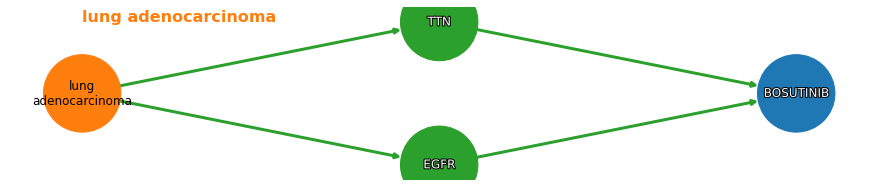

In [15]:
res = display_graph(q1_drug_specific)